# Assignment 1: Texture Synthesis by Non-parametric Sampling

In this assignment, you will implement a seminal texture synthesis algorithm from Efros and Leung's 1999 paper "Texture Synthesis by Non-parametric Sampling". This algorithm was groundbreaking in its simplicity and effectiveness, influencing many subsequent works in texture synthesis, image completion, and generative models. You can access the paper here: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=790383&tag=1.

Upon finishing this assignment, you are expected to synthesize textures like:
![example](./result0.png)

You will also visualize how this algorithm gradually fills the entire image:
![example_step1](./0-1.png) | ![example_step2](./0-2.png) | ![example_step3](./0-3.png)
:--------------------------:|:---------------------------:|:---------------------------:


Please:
* Fill out the code marked with `TODO` or `Your code here`.
* Run your code and provided support functions following the instructions.
* Submit the notebook with all original outputs. DO NOT DELETE OUTPUTS!
* Answer questions at the end of the notebook. Write your answere in the notebook.

## Part 1: Setup and Helper Functions

The following cells contain helper functions that are provided for you to use directly. These functions handle image loading, visualization, and other utilities that will help you focus on implementing the core texture synthesis algorithm. All necessary imports are included - you won't need additional libraries for the main assignment. (Extra credit portions may require additional imports.)

These helper functions provide key functionality you'll need throughout the assignment:

1. `load_texture`: Handles image loading, conversion to grayscale, and normalization
2. `visualize_progress`: Helps you debug by showing the synthesis progress
3. `get_unfilled_neighbors_count`: Helps determine the order of pixel synthesis

You can use these functions as-is and focus on implementing the core algorithm components in the following sections. The imports provided here include everything needed for the main assignment tasks.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from typing import Tuple, Optional

In [16]:
def load_texture(path: str, size: Optional[Tuple[int, int]] = None) -> np.ndarray:
    """Load a texture image and optionally resize it.
    
    Args:
        path: Path to the image file
        size: Optional tuple of (width, height) to resize the image to
        
    Returns:
        Loaded image as a numpy array with values in [0,1]
    """
    print(path)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if size:
        img = cv2.resize(img, size)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Original Texture')
    plt.show()
    return np.array(img) / 255.0

In [17]:
def visualize_progress(synthesized, mask, step=0):
    """Visualize the original texture and synthesis progress.
    
    Args:
        synthesized: Current state of synthesized texture
        mask: Binary mask showing filled pixels (1 = filled)
        step: Which step is now.
    """
    plt.figure(figsize=(5, 2))
    plt.subplot(121)
    plt.imshow(synthesized, cmap='gray')
    plt.title('Synthesized Texture')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(mask, cmap='gray')
    plt.title("Filled Pixel")
    plt.axis('off')
    plt.suptitle(f"Step {step}", y=0) 
    plt.show()

In [18]:
def get_unfilled_neighbors_count(mask: np.ndarray, window_size: int) -> np.ndarray:
    """Count number of filled neighbors for each unfilled pixel.
    
    Args:
        mask: Binary mask of filled pixels
        window_size: Size of neighborhood window
    
    Returns:
        Array with counts of filled neighbors for each unfilled pixel
    """
    kernel = np.ones((window_size, window_size))
    neighbors_count = cv2.filter2D(mask.astype(float), -1, kernel)
    neighbors_count[mask > 0] = -1  # Mark filled pixels with -1
    return neighbors_count

## Part 2: Implement Gaussian Window Creation (20pt)

The algorithm uses a Gaussian-weighted window when comparing neighborhoods.

The function should:

1. Create a window with the specified size (which should be odd)
2. Generate a Gaussian falloff from the center

You should use the following cell to test your gaussian window. Please keep the output.

In [19]:
def create_gaussian_window(window_size: int, sigma: float = 1.0) -> np.ndarray:
    """Create a Gaussian window for neighborhood weighting.
    
    Args:
        window_size: Size of the window (should be odd)
        sigma: Standard deviation of the Gaussian
        
    Returns:
        2D Gaussian window
    """
    # TODO: Implement this function
    # Hint: Use np.meshgrid and the Gaussian formula exp(-(x² + y²)/(2σ²))
    # The window should be highest in the center and decay towards the edges

    assert window_size % 2 == 1, "Window size must be odd."

    # Create a coordinate grid centered at 0
    ax = np.arange(-(window_size // 2), window_size // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)

    # Apply Gaussian formula
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))

    return kernel
    pass ### REMOVED

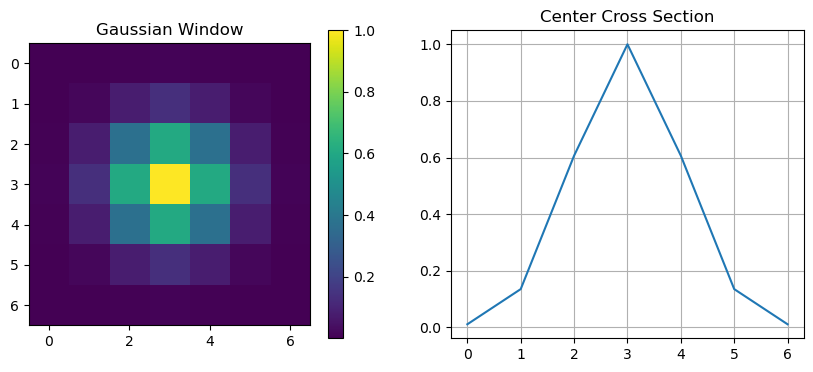

Window shape: (7, 7)
Max value (should be 1.0): 1.0
Center value (should be 1.0): 1.0
Corner value (should be small): 0.00012340980408667956
Window is symmetric: True


In [20]:
def test_gaussian_window():
    # Create a 7x7 window
    window = create_gaussian_window(7, sigma=1.0)
    
    # Visualize the window
    plt.figure(figsize=(10, 4))
    
    plt.subplot(121)
    plt.imshow(window, cmap='viridis')
    plt.colorbar()
    plt.title('Gaussian Window')
    
    plt.subplot(122)
    plt.plot(window[window.shape[0]//2, :])
    plt.title('Center Cross Section')
    plt.grid(True)
    plt.show()
    
    # Basic checks
    print("Window shape:", window.shape)
    print("Max value (should be 1.0):", window.max())
    print("Center value (should be 1.0):", window[window.shape[0]//2, window.shape[0]//2])
    print("Corner value (should be small):", window[0,0])
    
    # Check symmetry
    print("Window is symmetric:", np.allclose(window, window.T))

test_gaussian_window()

## Part 3: Implement Neighborhood Matching (20pt)

This section implements the heart of the Efros-Leung algorithm: finding similar neighborhoods in the source texture. This is the most critical component that determines the quality of your synthesized texture. When synthesizing a pixel, we need to find all neighborhoods in the source texture that are "similar enough" to our target neighborhood, and then randomly choose one of them.

Key Challenges:

1. Handling partially-filled neighborhoods (only comparing valid pixels)
2. Efficient computation of neighborhood differences
3. Proper weighting of pixel differences using the Gaussian window
4. Selecting an appropriate similarity threshold

You should use the following cell to test your neighborhood matching. Please keep the output.

In [21]:
def find_matching_neighborhoods(target_neighborhood: np.ndarray,
                              source_texture: np.ndarray,
                              gaussian_window: np.ndarray,
                              valid_mask: np.ndarray,
                              threshold: float = 0.01) -> list:
    good_matches = []
    
    # TODO: Your code here
    # Hints:
    # 1. Account for valid padding when extracting neighborhoods
    # 2. Use the Gaussian window to weight the differences
    # 3. Normalize by the sum of valid weights
        # Get dimensions
    window_size = target_neighborhood.shape[0] # 5
    half_window = window_size // 2 # 2
    h, w = source_texture.shape
    
    # Calculate the sum of valid weights for normalization
    valid_weights = valid_mask * gaussian_window
    # print(valid_weights, valid_mask, valid_weights.shape)
    # print("valid_mask", valid_mask)
    total_valid_weight = np.sum(valid_weights)
    
    # If no valid pixels, return empty list
    if total_valid_weight == 0:
        return good_matches

    # Precompute the weighted target neighborhood
    weighted_target = target_neighborhood * valid_weights
    bestssd = 1000
    # Iterate through all possible positions in source texture
    for i in range(half_window, h - half_window):
        for j in range(half_window, w - half_window):
            # Extract neighborhood from source
            source_neighborhood = source_texture[i-half_window:i+half_window+1, 
                                               j-half_window:j+half_window+1]
            # print("source neigh", source_neighborhood)
            # Calculate weighted squared difference
            diff = (source_neighborhood - target_neighborhood) * valid_weights
            ssd = np.sum(diff ** 2) / total_valid_weight
            
            # Check if this is a good match
            if ssd <= threshold:
                good_matches.append((i, j))
                
    return good_matches

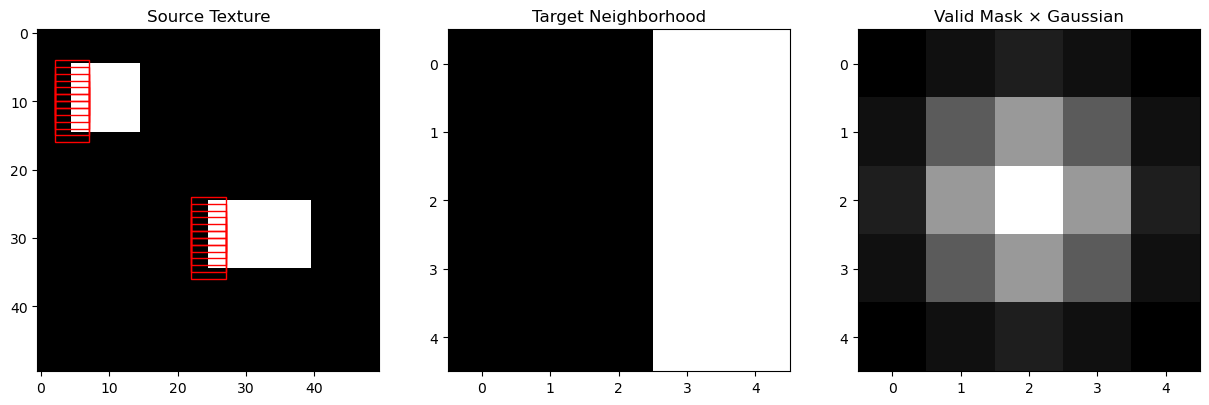

Found 16 matches


In [22]:
def test_neighborhood_matching():
    # Create a simple test texture
    source = np.zeros((20, 20))
    source[5:15, 5:15] = 1  # White square in center

    source = np.zeros((50, 50))
    source[5:15, 5:15] = 1  # White square in center

    source[25:35, 25:40] = 1
    # Create a target neighborhood that should match the edge of the square
    window_size = 5
    target = np.zeros((window_size, window_size))
    target[:, :3] = 0
    target[:, 3:] = 1
    # Create valid mask (all pixels valid in this test)
    valid_mask = np.ones_like(target)
    # Create Gaussian window
    gaussian = create_gaussian_window(window_size)
    # Find matches
    matches = find_matching_neighborhoods(target, source, gaussian, valid_mask)
    # Visualize
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(source, cmap='gray')
    plt.title('Source Texture')
    # Highlight matches
    for i, j in matches:
        rect = plt.Rectangle((j-window_size//2, i-window_size//2), 
                           window_size, window_size, 
                           fill=False, color='red')
        plt.gca().add_patch(rect)
    plt.subplot(132)
    plt.imshow(target, cmap='gray')
    plt.title('Target Neighborhood')
    plt.subplot(133)
    plt.imshow(valid_mask * gaussian, cmap='gray')
    plt.title('Valid Mask × Gaussian')
    plt.show()
    
    print(f"Found {len(matches)} matches")

test_neighborhood_matching()

## Part 4: Implement the Main Synthesis Loop (30pt)

This section brings together all the components to implement the complete Efros-Leung texture synthesis algorithm. The main synthesis loop grows the texture outward from an initial seed, carefully choosing the order of pixel synthesis and sampling from matching neighborhoods.

Key Concepts:

1. Seed Initialization: Start with a small patch from source texture
2. Growth Order: Always fill pixels with most known neighbors first
3. Partial Neighborhoods: Handle neighborhoods that are partially filled
4. Random Sampling: Choose randomly from valid matches to avoid repetition

Implementation Steps:
1. Initialization:
* Generate Gaussian window using your create_gaussian_window function
* Calculate window parameters (size, half-width)
2. Seed Placement:
* Copy a small patch (e.g., 3x3) from source texture
* Place it in center of output texture
* Update mask to mark seed pixels as filled
3. Main Loop:
* Use get_unfilled_neighbors_count to find next pixel to fill
* Extract partial neighborhood and create valid mask
* Use find_matching_neighborhoods to find matches
* Randomly select one matching pixel
* Update output texture and mask

In [23]:
def synthesize_texture(source_texture: np.ndarray,
                      output_size: Tuple[int, int],
                      window_size: int = 15,
                      threshold: float = 0.01,
                      visualize: bool = True) -> np.ndarray:
    """Synthesize a new texture using Efros & Leung's algorithm.
    
    Args:
        source_texture: Source texture to sample from
        output_size: Size of texture to synthesize (height, width)
        window_size: Size of neighborhood window (should be odd)
        threshold: Threshold for neighborhood matching
        
    Returns:
        Synthesized texture as numpy array
    """
    # Initialize output texture with zeros and the seed_size
    output = np.zeros(output_size)
    mask = np.zeros(output_size, dtype=bool)
    seed_size = 3
    
    # TODO: Your code here
    # Hints:
    # 1. Use helper functions provided
    # 2. Remember to handle boundary conditions
    
    num_iter = # Your code here: How many iterations are needed to fill the output?
    for i in range(num_iter):
        
        # TODO: Your code here
        
        if i % 1000 == 0 and visualize:
            visualize_progress(output, mask, step=i)
            # Use the visualization function to help you debug.
            # Keep the output when submitting.
    return output

SyntaxError: invalid syntax (619261714.py, line 27)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from typing import Tuple, List

def get_unfilled_neighbors(mask: np.ndarray) -> List[Tuple[int, int]]:
    """
    Returns a list of all unfilled pixels that have filled pixels as neighbors.
    The list is randomly permuted and sorted by decreasing number of filled neighbors.
    """
    # Create dilation kernel (3x3 cross or square)
    kernel = np.ones((3, 3), dtype=np.uint8)
    
    # Dilate the mask to get pixels adjacent to filled regions
    dilated_mask = cv2.dilate(mask.astype(np.uint8), kernel)
    
    # Unfilled neighbors = dilated pixels minus already filled pixels
    unfilled_neighbors_mask = dilated_mask - mask
    
    # Get coordinates of unfilled neighbors
    neighbor_coords = np.where(unfilled_neighbors_mask > 0)
    pixel_list = list(zip(neighbor_coords[0], neighbor_coords[1]))
    
    # Randomly permute the list
    np.random.shuffle(pixel_list)
    
    # Count filled neighbors for each pixel and sort by descending count
    def count_filled_neighbors(i, j):
        count = 0
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                ni, nj = i + di, j + dj
                if (0 <= ni < mask.shape[0] and 0 <= nj < mask.shape[1] 
                    and mask[ni, nj] > 0):
                    count += 1
        return count
    
    # Sort by number of filled neighbors (descending)
    pixel_list.sort(key=lambda coord: count_filled_neighbors(coord[0], coord[1]), 
                   reverse=True)
    
    return pixel_list

def get_neighborhood_window(image: np.ndarray, mask: np.ndarray, 
                          center_i: int, center_j: int, 
                          window_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns a window around the given pixel and the corresponding valid mask.
    Handles boundary conditions where window extends outside image.
    """
    half_window = window_size // 2
    h, w = image.shape
    
    # Initialize empty window and mask
    window = np.zeros((window_size, window_size))
    valid_mask = np.zeros((window_size, window_size), dtype=bool)
    
    # Calculate bounds for the window
    i_start = max(0, center_i - half_window)
    i_end = min(h, center_i + half_window + 1)
    j_start = max(0, center_j - half_window)
    j_end = min(w, center_j + half_window + 1)
    
    # Calculate corresponding positions in the window
    win_i_start = half_window - (center_i - i_start)
    win_i_end = win_i_start + (i_end - i_start)
    win_j_start = half_window - (center_j - j_start)
    win_j_end = win_j_start + (j_end - j_start)
    
    # Fill the window and valid mask
    window[win_i_start:win_i_end, win_j_start:win_j_end] = image[i_start:i_end, j_start:j_end]
    valid_mask[win_i_start:win_i_end, win_j_start:win_j_end] = mask[i_start:i_end, j_start:j_end]
    
    return window, valid_mask
def find_matches(template: np.ndarray, valid_mask: np.ndarray,
                source_image: np.ndarray, gaussian_window: np.ndarray,
                err_threshold: float = 0.1) -> List[Tuple[int, int]]:
    """
    Finds all pixels in source image whose neighborhoods match the template.
    Uses standard squared error with Gaussian weighting.
    """
    window_size = template.shape[0]
    half_window = window_size // 2
    h, w = source_image.shape
    
    # Calculate total valid weight
    valid_weights = gaussian_window * valid_mask
    total_weight = np.sum(valid_weights)
    
    if total_weight == 0:
        return []
    
    best_ssd = float('inf')
    all_ssds = []
    matches = []
    
    # Iterate through all possible positions in source image
    for i in range(half_window, h - half_window):
        for j in range(half_window, w - half_window):
            # Extract source neighborhood
            source_patch = source_image[i-half_window:i+half_window+1, 
                                      j-half_window:j+half_window+1]
            
            # Standard squared error calculation with Gaussian weighting
            # For each pixel in the window, compute (source - target)^2 * weight
            # Only consider pixels that are valid in the template
            ssd = 0.0
            for ii in range(window_size):
                for jj in range(window_size):
                    if valid_mask[ii, jj]:  # Only consider valid pixels
                        diff = source_patch[ii, jj] - template[ii, jj]
                        weight = valid_weights[ii, jj]
                        ssd += (diff * diff) * weight
            
            # Normalize by total weight
            ssd /= total_weight
            
            all_ssds.append(ssd)
            if ssd < best_ssd:
                best_ssd = ssd
    
    # Find all matches within error threshold
    threshold = best_ssd * (1 + err_threshold)
    idx = 0
    for i in range(half_window, h - half_window):
        for j in range(half_window, w - half_window):
            if all_ssds[idx] <= threshold:
                matches.append((i, j))
            idx += 1
    
    return matches
'''
def find_matches(template: np.ndarray, valid_mask: np.ndarray,
                source_image: np.ndarray, gaussian_window: np.ndarray,
                err_threshold: float = 0.1) -> List[Tuple[int, int]]:
    """
    Finds all pixels in source image whose neighborhoods match the template.
    """
    window_size = template.shape[0]
    half_window = window_size // 2
    h, w = source_image.shape
    
    # Calculate total valid weight
    valid_weights = gaussian_window * valid_mask
    total_weight = np.sum(valid_weights)
    
    if total_weight == 0:
        return []
    
    # Precompute the constant part of SSD for optimization
    template_weighted = template * valid_weights
    constant_term = np.sum(template_weighted * template) / total_weight
    
    best_ssd = float('inf')
    all_ssds = []
    matches = []
    
    # Iterate through all possible positions in source image
    for i in range(half_window, h - half_window):
        for j in range(half_window, w - half_window):
            # Extract source neighborhood
            source_patch = source_image[i-half_window:i+half_window+1, 
                                      j-half_window:j+half_window+1]
            
            # Compute weighted cross-correlation terms
            term1 = np.sum(source_patch * source_patch * valid_weights)
            term2 = -2 * np.sum(source_patch * template_weighted)
            ssd = (term1 + term2) / total_weight + constant_term
            
            all_ssds.append(ssd)
            if ssd < best_ssd:
                best_ssd = ssd
    
    # Find all matches within error threshold
    threshold = best_ssd * (1 + err_threshold)
    idx = 0
    for i in range(half_window, h - half_window):
        for j in range(half_window, w - half_window):
            if all_ssds[idx] <= threshold:
                matches.append((i, j))
            idx += 1
    
    return matches
'''

def grow_image(sample_image: np.ndarray, image: np.ndarray, 
              mask: np.ndarray, window_size: int = 15,
              initial_threshold: float = 0.01,
              visualize: bool = True) -> np.ndarray:
    """
    Main texture synthesis algorithm with fallback mechanism.
    """
    # Algorithm parameters
    err_threshold = initial_threshold
    max_err_threshold = 0.3  # Maximum allowed error threshold
    sigma = window_size / 6.4
    patience_counter = 0  # Counter for consecutive failures
    max_patience = 5     # Maximum patience before using fallback
    
    # Create Gaussian window
    gaussian_window = create_gaussian_window(window_size, sigma)
    
    iteration = 0
    while np.any(mask == 0):  # While image not filled
        progress = 0
        pixel_list = get_unfilled_neighbors(mask)
        
        for i, j in pixel_list:
            # Get neighborhood window around current pixel
            template, template_valid_mask = get_neighborhood_window(image, mask, i, j, window_size)
            
            # Find matching neighborhoods in source image
            matches = find_matches(template, template_valid_mask, sample_image, 
                                 gaussian_window, err_threshold)
            
            if matches:
                # Randomly pick a match
                match_i, match_j = matches[np.random.randint(len(matches))]
                
                # Update the pixel value
                image[i, j] = sample_image[match_i, match_j]
                mask[i, j] = 1
                progress = 1
                patience_counter = 0  # Reset patience counter on success
            else:
                print("did not find")
                # No matches found, increment patience counter
                patience_counter += 1
                
                # If we've been patient enough, use fallback strategy
                if patience_counter > 0:#max_patience:
                    # Use average of nearby filled pixels as fallback
                    fallback_value = get_average_of_neighbors(image, mask, i, j)
                    if fallback_value is not None:
                        image[i, j] = fallback_value
                        mask[i, j] = 1
                        progress = 1
                        patience_counter = 0  # Reset after fallback
                        print(f"Using fallback at ({i}, {j}) with value {fallback_value:.3f}")
        
        # If no progress was made, increase error threshold
        if not progress:
            err_threshold = min(err_threshold * 1.1, max_err_threshold)
            print(f"Increasing error threshold to {err_threshold:.3f}")
        
        # Visualize progress
        if iteration % 10 == 0 and visualize:
            visualize_progress(image, mask, iteration)
        
        iteration += 1
    
    if visualize:
        visualize_progress(image, mask, iteration)
    
    return image

def get_average_of_neighbors(image: np.ndarray, mask: np.ndarray, 
                           i: int, j: int) -> Optional[float]:
    """
    Calculate the average value of filled neighboring pixels.
    Returns None if no filled neighbors exist.
    """
    h, w = image.shape
    neighbor_values = []
    neighbor_weights = []
    
    # Check all 8-connected neighbors
    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            if di == 0 and dj == 0:
                continue  # Skip the center pixel itself
                
            ni, nj = i + di, j + dj
            if (0 <= ni < h and 0 <= nj < w and mask[ni, nj] > 0):
                # Use Gaussian-like weighting (closer neighbors have more influence)
                weight = 1.0 / (abs(di) + abs(dj) + 1)  # Manhattan distance weighting
                neighbor_values.append(image[ni, nj])
                neighbor_weights.append(weight)
    
    if neighbor_values:
        # Calculate weighted average
        total_weight = sum(neighbor_weights)
        weighted_avg = sum(val * weight for val, weight in zip(neighbor_values, neighbor_weights)) / total_weight
        return weighted_avg
    
    return None


def synthesize_texture(source_texture: np.ndarray,
                      output_size: Tuple[int, int],
                      window_size: int = 15,
                      threshold: float = 0.01,
                      visualize: bool = True) -> np.ndarray:
    """
    Complete texture synthesis function with proper initialization.
    """
    output_h, output_w = output_size
    source_h, source_w = source_texture.shape
    
    # Initialize output image and mask
    image = np.zeros(output_size)
    mask = np.zeros(output_size, dtype=np.uint8)
    
    # Place 3x3 seed in center from random location in source
    seed_size = 3
    half_window = window_size // 2
    
    # Find valid seed location (avoid boundaries)
    seed_i = np.random.randint(half_window, source_h - half_window - seed_size)
    seed_j = np.random.randint(half_window, source_w - half_window - seed_size)
    
    center_h, center_w = output_h // 2, output_w // 2
    seed_patch = source_texture[seed_i:seed_i+seed_size, seed_j:seed_j+seed_size]
    
    image[center_h:center_h+seed_size, center_w:center_w+seed_size] = seed_patch
    mask[center_h:center_h+seed_size, center_w:center_w+seed_size] = 1
    
    # Grow the image
    result = grow_image(source_texture, image, mask, window_size, threshold, visualize)
    
    return result

## Part 5: Testing the Algorithm (30pt)
Now that you've implemented the complete texture synthesis algorithm, it's time to systematically test it with different textures and parameters. This section will help you understand how your implementation performs across various texture types and how different parameters affect the results.

texture0.jpg


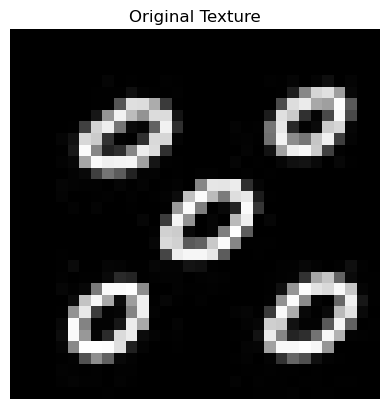

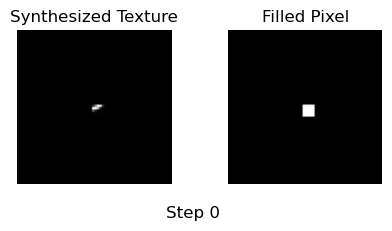

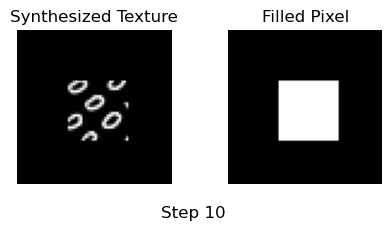

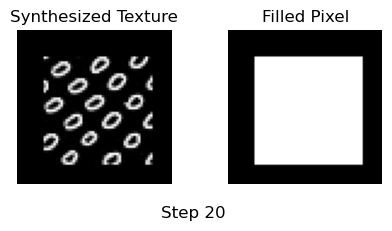

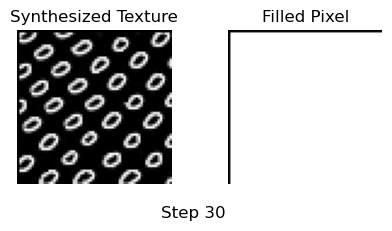

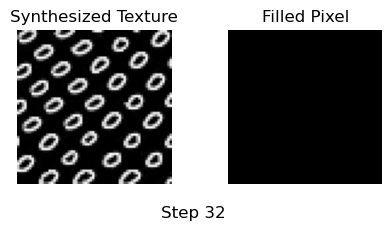

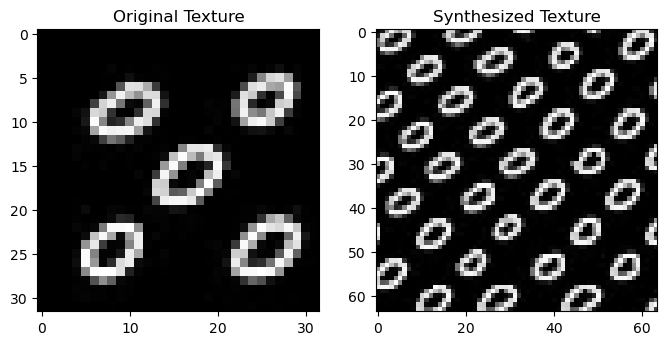

texture1.jpg


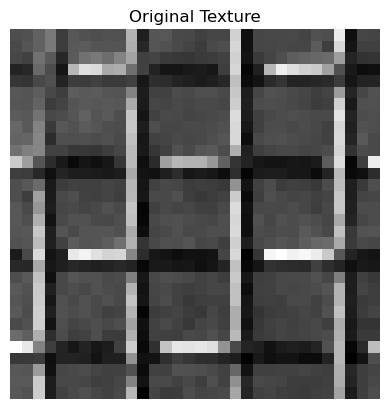

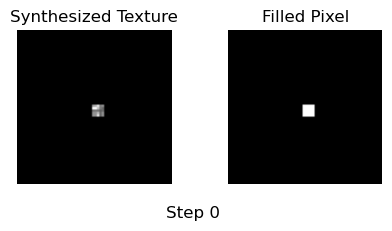

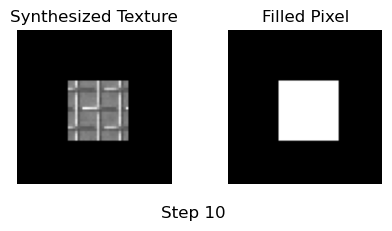

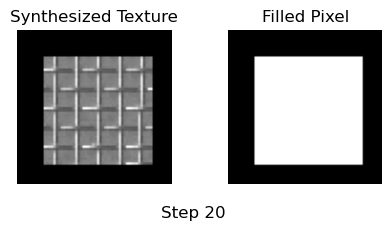

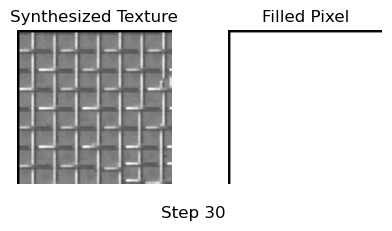

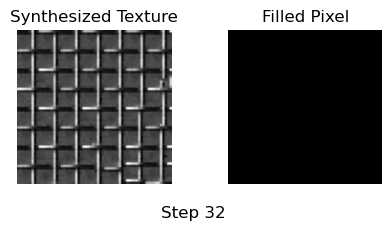

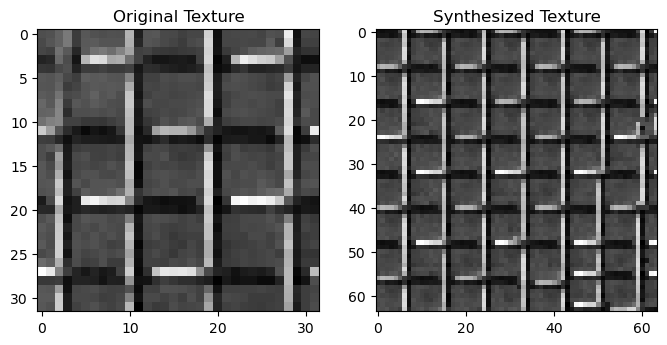

In [42]:
texture0 = 'texture0.jpg'
texture1 = 'texture1.jpg'
for texture_name in [texture0, texture1]:
    texture = load_texture(texture_name, (32, 32))
    
    synthesized = synthesize_texture(
        source_texture=texture,
        output_size=(64, 64),
        window_size=15,
        threshold=0.01
    )
    # Display results
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.imshow(texture, cmap='gray')
    plt.title('Original Texture')
    plt.subplot(122)
    plt.imshow(synthesized, cmap='gray')
    plt.title('Synthesized Texture')
    plt.show()

Now play with different parameters to see how they works in the algorithm.

The following code changes window_size. Please run it first to observe how does this parameter change influence the result. Next, write code to change at least one another parameter to see how the parameter change influence the result.

texture0.jpg


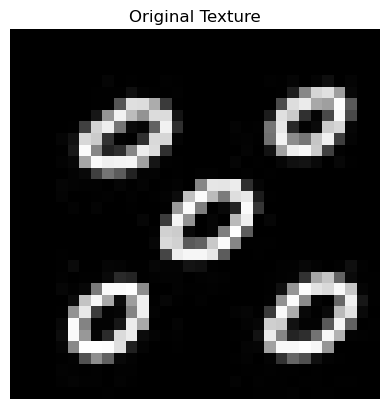

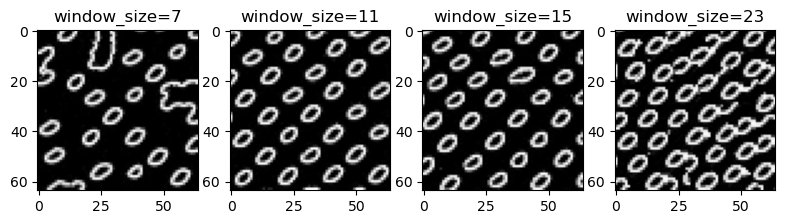

In [43]:
texture0 = 'texture0.jpg'
texture = load_texture(texture0, (32, 32))
window_sizes = [7, 11, 15, 23]
plt.figure(figsize=(12, 4))
plt.subplot(1, len(window_sizes) + 1, 1)
plt.imshow(texture, cmap='grey')
plt.title('Original')
for i, window_size in enumerate(window_sizes):
    synthesized = synthesize_texture(
        source_texture=texture,
        output_size=(64, 64),
        window_size=window_size,
        threshold=0.01,
        visualize=False
    )
    plt.subplot(1, len(window_sizes) + 1, i+1)
    plt.imshow(synthesized, cmap='gray')
    plt.title(f"window_size={window_size}")
plt.show()

In [ ]:
# TODO: Your code here. Test another parameter. Add more cells for other textures.

Answer the question with your analysis. Most of the questions are open-ended. We are looking for your own observasion from the experiments you did.

1. How does window size relate to the size of texture elements?

[Answer]:

2. What's the trade-off between threshold value and synthesis quality?

[Answer]:

3. What are the computational bottlenecks in your implementation? Any idea how it might be improved?

[Answer]:

4. Play with at least one texture you prepared yourself. Show the result (you can reuse the code above). Tell us what you noticed.

[Answer]:

# Extra Credit: Image Quilting Implementation

Now that you've implemented the Efros-Leung texture synthesis algorithm, you have a good foundation for implementing another seminal paper in texture synthesis - "Image Quilting for Texture Synthesis and Transfer" by Efros and Freeman (SIGGRAPH 2001). You can access the paper here: https://dl.acm.org/doi/pdf/10.1145/383259.383296


Your goal is to modify your existing texture synthesis code to implement the Image Quilting algorithm. Rather than synthesizing one pixel at a time, this algorithm:

1. Takes square blocks from the input texture and patches them together
2. Uses overlap between adjacent blocks to find good matches
3. Computes minimum error boundary cuts between overlapping blocks to reduce visual artifacts

Your implementation should include:

1. Random block placement for the first block
2. Finding matching blocks considering overlap regions
3. Computing minimum error boundary cuts using dynamic programming
4. Proper handling of both vertical and horizontal overlaps


Tips

* Start by implementing simple block copying without overlaps
* Add block matching using SSD in overlap regions
* Implement the minimum error boundary cut
* You can reuse your code for:
    * Image loading and visualization
    * Error computation between regions
    * Random sampling logic

## Extra Credit Part 1: Compute minimum error boundary cuts using DP (10pt)

Write a code to find minimum error boundary cut between two overlapping blocks.
Returns a binary mask the same size as the first block.

You will get 10 extra credit if you finish and test this part. Please provide code and at least one test case with visualization below to show the correctness of your code.

In [ ]:
def min_error_boundary(
    block1: np.ndarray,
    block2: np.ndarray,
    overlap_size: int,
    direction: str = 'vertical'  # or 'horizontal'
) -> np.ndarray:
    # TODO: Your code here
    pass

# TODO: Your test code here if you only did part 1. You can omit it if you have results for part 2.

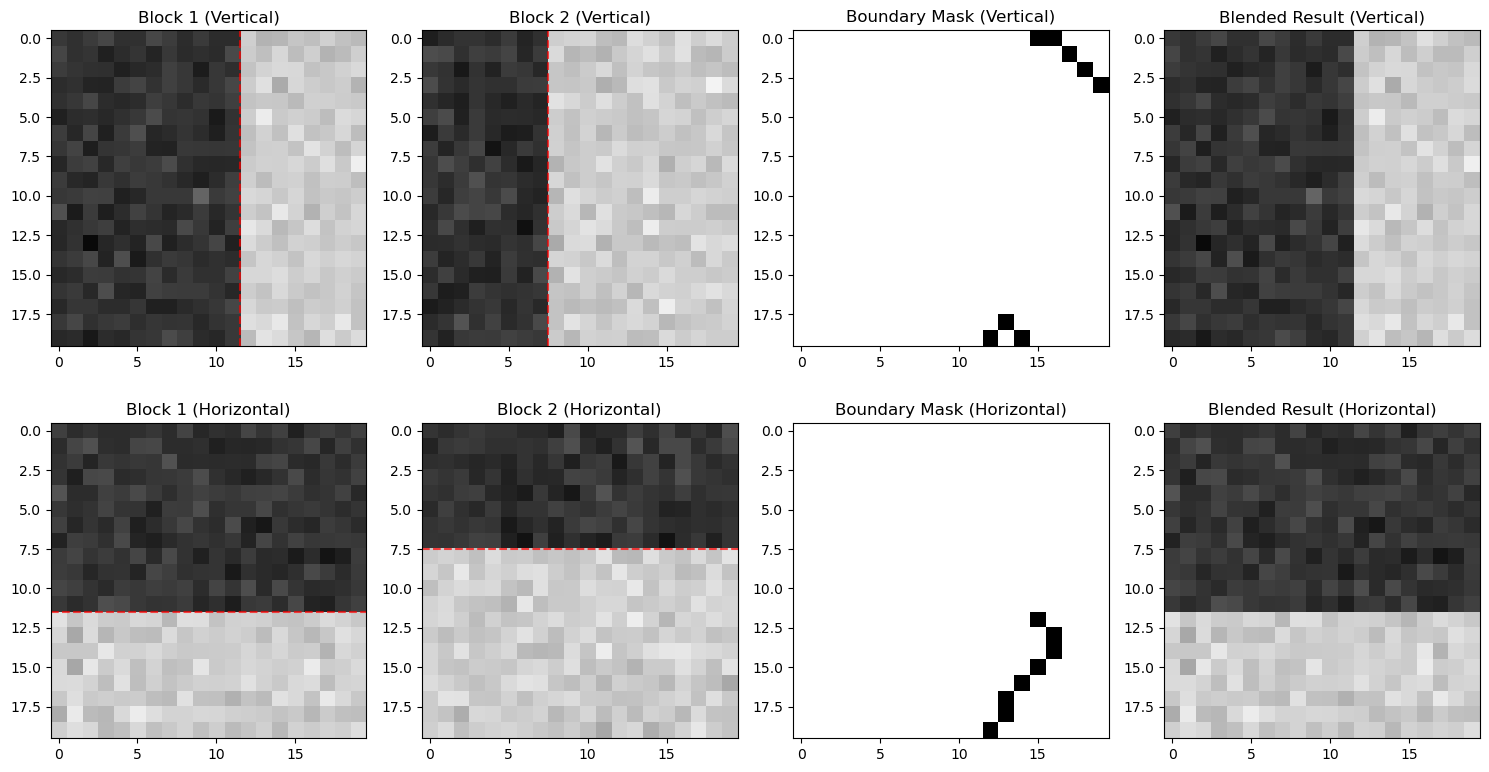

Test completed successfully!
Vertical mask shape: (20, 20)
Horizontal mask shape: (20, 20)
Vertical mask unique values: [False  True]
Horizontal mask unique values: [False  True]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from typing import Tuple, Optional, List

def min_error_boundary(
    block1: np.ndarray,
    block2: np.ndarray,
    overlap_size: int,
    direction: str = 'vertical'  # or 'horizontal'
) -> np.ndarray:
    """
    Find minimum error boundary cut between two overlapping blocks using dynamic programming.
    
    Args:
        block1: First block (usually the existing synthesized block)
        block2: Second block (usually the candidate block to be placed)
        overlap_size: Size of the overlap region
        direction: 'vertical' for left-right overlap, 'horizontal' for top-bottom overlap
        
    Returns:
        Binary mask the same size as block1 where True indicates pixels from block1
    """
    assert block1.shape == block2.shape, "Blocks must have the same shape"
    assert direction in ['vertical', 'horizontal'], "Direction must be 'vertical' or 'horizontal'"
    
    h, w = block1.shape
    
    if direction == 'vertical':
        # Vertical overlap: blocks overlap horizontally
        assert overlap_size <= w, "Overlap size must be <= block width"
        
        # Compute error surface (squared difference in overlap region)
        error_surface = (block1[:, -overlap_size:] - block2[:, :overlap_size]) ** 2
        
        # Initialize DP table and path table
        dp = np.zeros_like(error_surface)
        path = np.zeros_like(error_surface, dtype=int)
        
        # Initialize first column
        dp[:, 0] = error_surface[:, 0]
        
        # Fill DP table
        for j in range(1, overlap_size):
            for i in range(h):
                # Consider three possible paths: up, straight, down
                candidates = []
                if i > 0:
                    candidates.append(dp[i-1, j-1])
                candidates.append(dp[i, j-1])
                if i < h - 1:
                    candidates.append(dp[i+1, j-1])
                
                # Find minimum cost path
                min_idx = np.argmin(candidates)
                dp[i, j] = error_surface[i, j] + candidates[min_idx]
                path[i, j] = min_idx - 1 if min_idx == 0 else (0 if min_idx == 1 else 1)
        
        # Backtrack to find optimal path
        mask = np.ones_like(block1, dtype=bool)
        i = np.argmin(dp[:, -1])
        
        for j in range(overlap_size-1, -1, -1):
            # Set mask: True for block1, False for block2
            mask[i, w - overlap_size + j] = False
            i += path[i, j]
    
    else:  # horizontal direction
        # Horizontal overlap: blocks overlap vertically
        assert overlap_size <= h, "Overlap size must be <= block height"
        
        # Compute error surface (squared difference in overlap region)
        error_surface = (block1[-overlap_size:, :] - block2[:overlap_size, :]) ** 2
        
        # Initialize DP table and path table
        dp = np.zeros_like(error_surface)
        path = np.zeros_like(error_surface, dtype=int)
        
        # Initialize first row
        dp[0, :] = error_surface[0, :]
        
        # Fill DP table
        for i in range(1, overlap_size):
            for j in range(w):
                # Consider three possible paths: left, straight, right
                candidates = []
                if j > 0:
                    candidates.append(dp[i-1, j-1])
                candidates.append(dp[i-1, j])
                if j < w - 1:
                    candidates.append(dp[i-1, j+1])
                
                # Find minimum cost path
                min_idx = np.argmin(candidates)
                dp[i, j] = error_surface[i, j] + candidates[min_idx]
                path[i, j] = min_idx - 1 if min_idx == 0 else (0 if min_idx == 1 else 1)
        
        # Backtrack to find optimal path
        mask = np.ones_like(block1, dtype=bool)
        j = np.argmin(dp[-1, :])
        
        for i in range(overlap_size-1, -1, -1):
            # Set mask: True for block1, False for block2
            mask[h - overlap_size + i, j] = False
            j += path[i, j]
    
    return mask

# Test function for min_error_boundary
def test_min_error_boundary():
    """Test the minimum error boundary cut function with synthetic data."""
    
    # Create test blocks with a clear boundary
    block_size = 20
    overlap_size = 8
    
    # Block 1: Left side dark, right side bright with a clear vertical boundary
    block1 = np.ones((block_size, block_size)) * 0.2
    boundary_pos = block_size - overlap_size
    block1[:, boundary_pos:] = 0.8
    
    # Block 2: Right side dark, left side bright (opposite of block1)
    block2 = np.ones((block_size, block_size)) * 0.8
    block2[:, :overlap_size] = 0.2
    
    # Add some noise to make it more realistic
    np.random.seed(42)
    block1 += np.random.normal(0, 0.05, block1.shape)
    block2 += np.random.normal(0, 0.05, block2.shape)
    block1 = np.clip(block1, 0, 1)
    block2 = np.clip(block2, 0, 1)
    
    # Test vertical boundary cut
    mask_vertical = min_error_boundary(block1, block2, overlap_size, 'vertical')
    
    # Test horizontal boundary cut
    # Create different test blocks for horizontal case
    block1_h = np.ones((block_size, block_size)) * 0.2
    block1_h[boundary_pos:, :] = 0.8
    
    block2_h = np.ones((block_size, block_size)) * 0.8
    block2_h[:overlap_size, :] = 0.2
    
    block1_h += np.random.normal(0, 0.05, block1_h.shape)
    block2_h += np.random.normal(0, 0.05, block2_h.shape)
    block1_h = np.clip(block1_h, 0, 1)
    block2_h = np.clip(block2_h, 0, 1)
    
    mask_horizontal = min_error_boundary(block1_h, block2_h, overlap_size, 'horizontal')
    
    # Visualize results
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    
    # Vertical case
    axes[0, 0].imshow(block1, cmap='gray', vmin=0, vmax=1)
    axes[0, 0].set_title('Block 1 (Vertical)')
    axes[0, 0].axvline(x=boundary_pos-0.5, color='red', linestyle='--', alpha=0.7)
    
    axes[0, 1].imshow(block2, cmap='gray', vmin=0, vmax=1)
    axes[0, 1].set_title('Block 2 (Vertical)')
    axes[0, 1].axvline(x=overlap_size-0.5, color='red', linestyle='--', alpha=0.7)
    
    # Show the mask and blended result
    blended_vertical = np.where(mask_vertical, block1, block2)
    axes[0, 2].imshow(mask_vertical, cmap='gray')
    axes[0, 2].set_title('Boundary Mask (Vertical)')
    
    axes[0, 3].imshow(blended_vertical, cmap='gray', vmin=0, vmax=1)
    axes[0, 3].set_title('Blended Result (Vertical)')
    
    # Horizontal case
    axes[1, 0].imshow(block1_h, cmap='gray', vmin=0, vmax=1)
    axes[1, 0].set_title('Block 1 (Horizontal)')
    axes[1, 0].axhline(y=boundary_pos-0.5, color='red', linestyle='--', alpha=0.7)
    
    axes[1, 1].imshow(block2_h, cmap='gray', vmin=0, vmax=1)
    axes[1, 1].set_title('Block 2 (Horizontal)')
    axes[1, 1].axhline(y=overlap_size-0.5, color='red', linestyle='--', alpha=0.7)
    
    # Show the mask and blended result
    blended_horizontal = np.where(mask_horizontal, block1_h, block2_h)
    axes[1, 2].imshow(mask_horizontal, cmap='gray')
    axes[1, 2].set_title('Boundary Mask (Horizontal)')
    
    axes[1, 3].imshow(blended_horizontal, cmap='gray', vmin=0, vmax=1)
    axes[1, 3].set_title('Blended Result (Horizontal)')
    
    plt.tight_layout()
    plt.show()
    
    print("Test completed successfully!")
    print(f"Vertical mask shape: {mask_vertical.shape}")
    print(f"Horizontal mask shape: {mask_horizontal.shape}")
    print(f"Vertical mask unique values: {np.unique(mask_vertical)}")
    print(f"Horizontal mask unique values: {np.unique(mask_horizontal)}")

# Run the test
test_min_error_boundary()

In [ ]:
def synthesize_texture_quilting(
    source_texture: np.ndarray,
    output_size: Tuple[int, int],
    block_size: int = 20,
    overlap_size: int = 6,
    threshold: float = 0.1,
    random_seed: Optional[int] = None
) -> np.ndarray:
    """
    Implement the Image Quilting algorithm from Efros and Freeman (2001).
    
    Args:
        source_texture: Source texture to sample from
        output_size: Size of output texture (height, width)
        block_size: Size of square blocks to extract
        overlap_size: Size of overlap region between blocks
        tolerance: Tolerance for block matching (0-1)
        random_seed: Optional random seed for reproducibility
        
    Returns:
        Synthesized texture
    """
    tolerance = threshold
    if random_seed is not None:
        np.random.seed(random_seed)
    
    h_out, w_out = output_size
    h_src, w_src = source_texture.shape
    
    # Initialize output texture
    output = np.zeros(output_size)
    mask = np.zeros(output_size, dtype=bool)  # Track which pixels are filled
    
    # Calculate grid dimensions
    num_blocks_h = (h_out - overlap_size) // (block_size - overlap_size) + 1
    num_blocks_w = (w_out - overlap_size) // (block_size - overlap_size) + 1
    
    # Place first block randomly
    i0 = np.random.randint(0, h_src - block_size)
    j0 = np.random.randint(0, w_src - block_size)
    first_block = source_texture[i0:i0+block_size, j0:j0+block_size]
    
    output[:block_size, :block_size] = first_block
    mask[:block_size, :block_size] = True
    
    # Place blocks row by row
    for row in range(num_blocks_h):
        for col in range(num_blocks_w):
            if row == 0 and col == 0:  # Skip first block
                continue
                
            # Calculate position for current block
            y_start = row * (block_size - overlap_size)
            x_start = col * (block_size - overlap_size)
            y_end = min(y_start + block_size, h_out)
            x_end = min(x_start + block_size, w_out)
            
            # Determine overlap regions
            vertical_overlap = None
            horizontal_overlap = None
            
            if row > 0:  # Has top overlap
                top_overlap_region = output[y_start:y_start+overlap_size, x_start:x_end]
                horizontal_overlap = top_overlap_region
            
            if col > 0:  # Has left overlap
                left_overlap_region = output[y_start:y_end, x_start:x_start+overlap_size]
                vertical_overlap = left_overlap_region
            
            # Find best matching block
            best_block, best_i, best_j = find_best_block(
                source_texture, block_size, vertical_overlap, horizontal_overlap, tolerance
            )
            
            # Place the block with minimum error boundary cut
            if vertical_overlap is not None and horizontal_overlap is not None:
                # Both overlaps - need to handle corner case
                current_output_region = output[y_start:y_end, x_start:x_end]
                mask_region = mask[y_start:y_end, x_start:x_end]
                
                # Create temporary block for boundary cut
                temp_block = np.zeros_like(current_output_region)
                temp_block[:] = current_output_region
                
                # Apply vertical boundary cut first
                if vertical_overlap is not None:
                    vert_mask = min_error_boundary(
                        temp_block[:, :overlap_size], 
                        best_block[:, :overlap_size], 
                        overlap_size, 'vertical'
                    )
                    temp_block[:, :overlap_size] = np.where(
                        vert_mask, temp_block[:, :overlap_size], best_block[:, :overlap_size]
                    )
                
                # Apply horizontal boundary cut
                if horizontal_overlap is not None:
                    horz_mask = min_error_boundary(
                        temp_block[:overlap_size, :], 
                        best_block[:overlap_size, :], 
                        overlap_size, 'horizontal'
                    )
                    temp_block[:overlap_size, :] = np.where(
                        horz_mask, temp_block[:overlap_size, :], best_block[:overlap_size, :]
                    )
                
                output[y_start:y_end, x_start:x_end] = temp_block
                
            elif vertical_overlap is not None:
                # Only vertical overlap
                current_output_region = output[y_start:y_end, x_start:x_start+overlap_size]
                mask_vert = min_error_boundary(
                    current_output_region, best_block[:, :overlap_size], overlap_size, 'vertical'
                )
                output[y_start:y_end, x_start:x_end] = best_block
                output[y_start:y_end, x_start:x_start+overlap_size] = np.where(
                    mask_vert, current_output_region, best_block[:, :overlap_size]
                )
                
            elif horizontal_overlap is not None:
                # Only horizontal overlap
                current_output_region = output[y_start:y_start+overlap_size, x_start:x_end]
                mask_horz = min_error_boundary(
                    current_output_region, best_block[:overlap_size, :], overlap_size, 'horizontal'
                )
                output[y_start:y_end, x_start:x_end] = best_block
                output[y_start:y_start+overlap_size, x_start:x_end] = np.where(
                    mask_horz, current_output_region, best_block[:overlap_size, :]
                )
            
            else:
                # No overlap (shouldn't happen in normal grid placement)
                output[y_start:y_end, x_start:x_end] = best_block
            
            mask[y_start:y_end, x_start:x_end] = True
    
    return output

def find_best_block(
    source_texture: np.ndarray,
    block_size: int,
    vertical_overlap: Optional[np.ndarray],
    horizontal_overlap: Optional[np.ndarray],
    tolerance: float
) -> Tuple[np.ndarray, int, int]:
    """
    Find the best matching block considering overlap constraints.
    """
    h_src, w_src = source_texture.shape
    candidates = []
    errors = []
    
    # Search through all possible block positions
    for i in range(0, h_src - block_size):
        for j in range(0, w_src - block_size):
            candidate_block = source_texture[i:i+block_size, j:j+block_size]
            error = 0
            
            # Check vertical overlap (left side)
            if vertical_overlap is not None:
                vert_error = np.mean((candidate_block[:, :vertical_overlap.shape[1]] - vertical_overlap) ** 2)
                error += vert_error
            
            # Check horizontal overlap (top side)
            if horizontal_overlap is not None:
                horz_error = np.mean((candidate_block[:horizontal_overlap.shape[0], :] - horizontal_overlap) ** 2)
                error += horz_error
            
            # If no overlap constraints, use random selection
            if vertical_overlap is None and horizontal_overlap is None:
                error = np.random.random()
            
            candidates.append((candidate_block, i, j))
            errors.append(error)
    
    # Find best matches within tolerance
    errors = np.array(errors)
    min_error = np.min(errors)
    threshold = min_error * (1 + tolerance)
    
    good_matches = [candidates[i] for i in range(len(candidates)) if errors[i] <= threshold]
    
    if not good_matches:
        # Fallback: return the best match regardless of tolerance
        best_idx = np.argmin(errors)
        return candidates[best_idx]
    
    # Randomly select from good matches
    return good_matches[np.random.randint(len(good_matches))]

# Test the complete image quilting algorithm
def test_image_quilting():
    """Test the complete image quilting algorithm."""
    
    # Load a simple texture
    texture = np.zeros((50, 50))
    texture[10:20, 10:20] = 0.8  # Bright square
    texture[30:40, 30:40] = 0.8  # Another bright square
    
    # Add some noise
    texture += np.random.normal(0, 0.1, texture.shape)

NameError: name 'np' is not defined

## Extra Credit Part 2: Synthesize texture quiltering (10pt)

Finish your code using the function you wrote above.

You can get another 10 extra credit if you finish and test it below. Please keep all output.

In [ ]:
# TODO: Your code here. You can add any supporting functions you like.

def synthesize_texture_quilting(
    source_texture: np.ndarray,
    output_size: Tuple[int, int],
    block_size: int = 32,
    overlap_size: int = 8,
    threshold: float = 0.1,
    visualize: bool = True
) -> np.ndarray:
    # TODO: Your code here
    pass

texture3.jpg


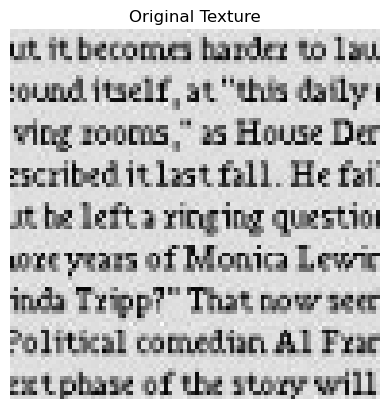

TypeError: Image data of dtype object cannot be converted to float

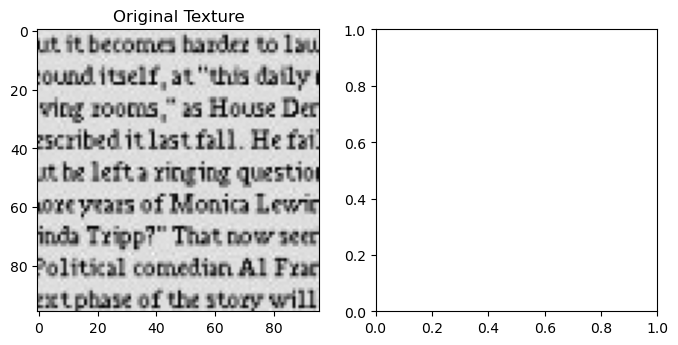

In [ ]:
texture = load_texture("texture3.jpg", (96, 96))

# Synthesize new texture
synthesized = synthesize_texture_quilting(
    source_texture=texture,
    output_size=(256, 256),
    block_size=64,
    overlap_size=16,
    threshold=0.1
)

# Display results
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(texture, cmap='gray')
plt.title('Original Texture')
plt.subplot(122)
plt.imshow(synthesized, cmap='gray')
plt.title('Synthesized Texture')
plt.show()